# Train GAN on MNIST dataset


In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Settings

In [0]:
# Root directory for dataset
dataroot = "./data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. 1 for MNIST
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Dataset

In [0]:
# Create the dataset
dataset = dset.MNIST(
    root=dataroot,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
)

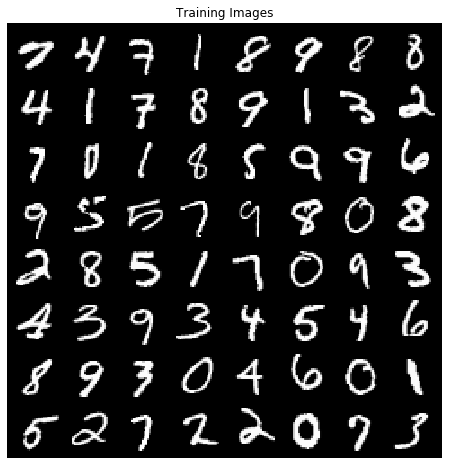

In [8]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## Generator

In [0]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 7x7
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 14x14
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 28x28
            nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [10]:
netG = Generator(ngpu).to(device)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [11]:
# Lets check that GAN generates image with correct shape (1, 1, 28, 28)

input_variable = torch.randn((1, 100, 1, 1, )).to(device)
netG(input_variable).shape

torch.Size([1, 1, 28, 28])

## Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 28x28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14x14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7x7
            nn.Conv2d(ndf * 2, ndf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4x4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 1x1
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [25]:
netD = Discriminator(ngpu).to(device)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)


In [26]:
# Lets check that Discriminator will return single number from input of size (1, 1, 28, 28)

input_variable = torch.randn((1, 1, 28, 28)).to(device)
# input_variable.shape
netD(input_variable)

tensor([[[[0.6096]]]], device='cuda:0', grad_fn=<SigmoidBackward>)

### Training GAN

In [0]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [28]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 20

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        #############################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        #############################################################
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        #############################################
        # (2) Update G network: maximize log(D(G(z)))
        #############################################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[1/20][0/938]	Loss_D: 1.3136	Loss_G: 2.4938	D(x): 0.5575	D(G(z)): 0.5045 / 0.0881
[1/20][50/938]	Loss_D: 0.0044	Loss_G: 11.4670	D(x): 0.9957	D(G(z)): 0.0000 / 0.0000
[1/20][100/938]	Loss_D: 0.3908	Loss_G: 9.6511	D(x): 0.9857	D(G(z)): 0.2936 / 0.0001
[1/20][150/938]	Loss_D: 0.0615	Loss_G: 5.7972	D(x): 0.9821	D(G(z)): 0.0387 / 0.0033
[1/20][200/938]	Loss_D: 0.0149	Loss_G: 7.2949	D(x): 0.9888	D(G(z)): 0.0034 / 0.0022
[1/20][250/938]	Loss_D: 0.0391	Loss_G: 5.1080	D(x): 0.9857	D(G(z)): 0.0238 / 0.0102
[1/20][300/938]	Loss_D: 0.0261	Loss_G: 4.0079	D(x): 0.9967	D(G(z)): 0.0213 / 0.0690
[1/20][350/938]	Loss_D: 0.0306	Loss_G: 6.1414	D(x): 0.9842	D(G(z)): 0.0143 / 0.0197
[1/20][400/938]	Loss_D: 0.0870	Loss_G: 4.5847	D(x): 0.9384	D(G(z)): 0.0167 / 0.0128
[1/20][450/938]	Loss_D: 0.3809	Loss_G: 2.7058	D(x): 0.7486	D(G(z)): 0.0475 / 0.0973
[1/20][500/938]	Loss_D: 0.1619	Loss_G: 3.5556	D(x): 0.9263	D(G(z)): 0.0726 / 0.0400
[1/20][550/938]	Loss_D: 0.3128	Loss_G: 2.6580	D(x): 

### Plot results

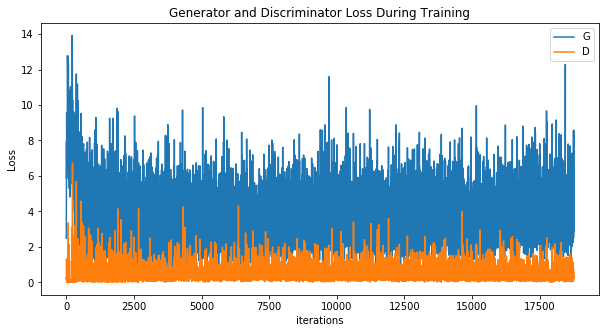

In [29]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

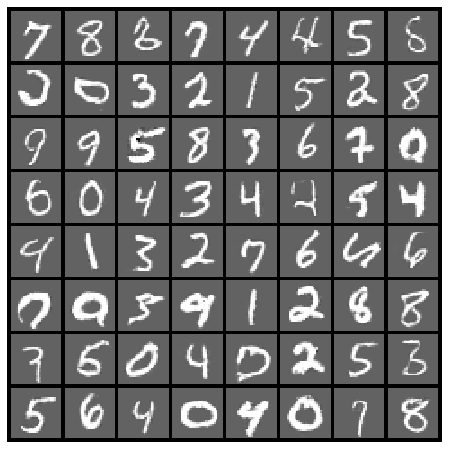

In [30]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

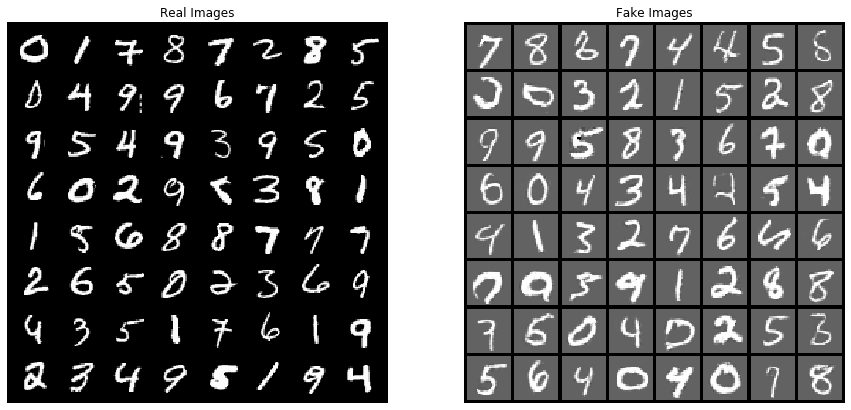

In [39]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

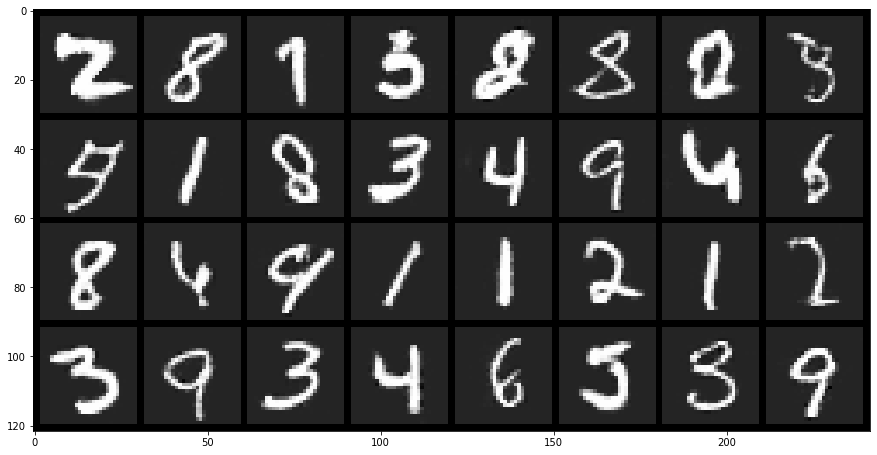

In [40]:
# Generate some new fake images
noise = torch.randn(b_size, nz, 1, 1, device=device)
with torch.no_grad():
    fake = netG(noise).cpu()
img = vutils.make_grid(fake, padding=2, normalize=True)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(img,(1,2,0)))

### Save model parameters

In [0]:
torch.save(netG.state_dict(), "generator_mnist.pth")
torch.save(netD.state_dict(), "discriminator_mnist.pth")

In [37]:
!ls

data  discriminator_mnist.pth  generator_mnist.pth  sample_data


In [0]:
from google.colab import files

files.download("generator_mnist.pth")
files.download("discriminator_mnist.pth")